In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, MobileViTV2ForImageClassification
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

# Check and create output directory
if not os.path.exists('./outputs'):
    os.mkdir('./outputs')

c:\Users\thanh-dung.le\.conda\envs\EfficientViT-Microsoft\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Global parameters
USE_CUDA = torch.cuda.is_available()
DATASET_PATH = 'C:\\Users\\thanh-dung.le\\Documents\\EuroSat_Satellite\\EuroSAT_RGB'
BATCH_SIZE = 64
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

In [3]:

# Check train and test directories
train_path = os.path.join(DATASET_PATH, 'train')
print(f"Train directory exists: {os.path.exists(train_path)}")
print(f"Classes in train directory: {os.listdir(train_path)}")
test_path = os.path.join(DATASET_PATH, 'test')
print(f"Test directory exists: {os.path.exists(test_path)}")
print(f"Classes in test directory: {os.listdir(test_path)}")

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize(224),  # Resizing to 256 as required by Mobile Transformer
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets and DataLoaders
train_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'train'), data_transforms)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'test'), data_transforms)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
class_names = train_dataset.classes

print('Dataloaders OK')

Train directory exists: True
Classes in train directory: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Test directory exists: True
Classes in test directory: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Dataloaders OK


Image label: 6


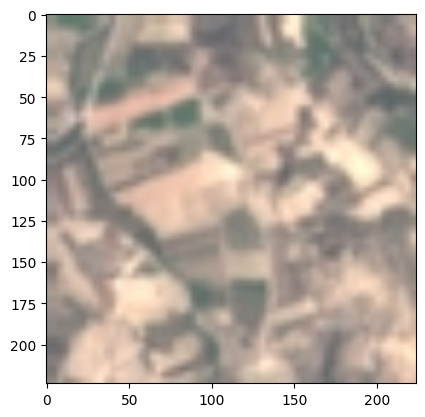

In [4]:
# Example data point visualization
random_image = train_dataset[13421][0].numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
random_image = std * random_image + mean
random_image = np.clip(random_image, 0, 1)
print("Image label:", train_dataset[13421][1])
plt.imshow(random_image)
plt.show()

In [5]:
# Define the path where the entire model will be saved
model_path = './outputs/EfficientViT_M2.pth'

In [6]:
# Load pre-trained model for inference
from classification.model.build import EfficientViT_M2
loaded_model = EfficientViT_M2(pretrained='efficientvit_m2')

# Modify the classifier to match the number of classes
loaded_model.head.l = nn.Linear(loaded_model.head.l.in_features, len(class_names))



# Load the state dictionary
loaded_model.load_state_dict(torch.load(model_path))

if USE_CUDA:
    loaded_model = loaded_model.cuda()

print('Model loaded and ready for inference')

Model loaded and ready for inference


C:\Users\thanh-dung.le\AppData\Local\Temp\ipykernel_71796\2011106559.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path)


Loaded model test results: Loss=0.0387905931646118 | Accuracy=98.76390605686032
Precision: 0.9876797819943823 | Recall: 0.9876390605686032
Inference Time for Loaded Model: 9.467668294906616 seconds



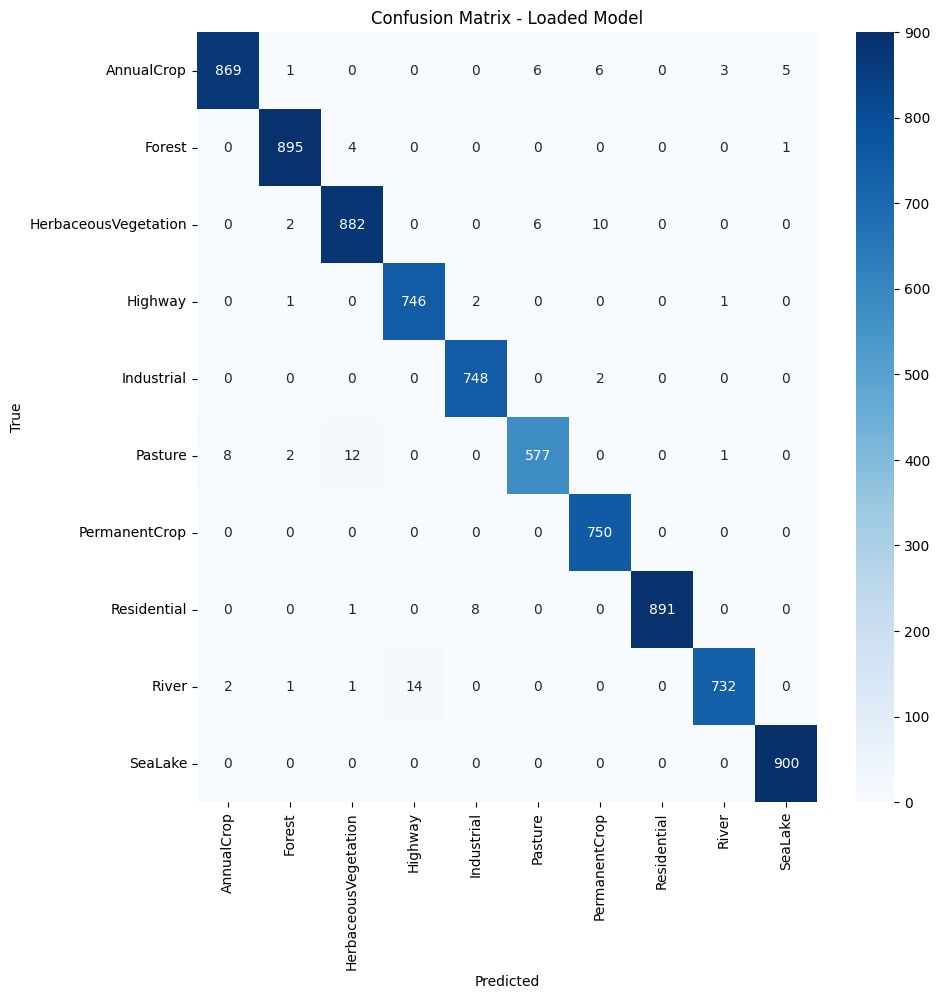

In [7]:
# Test the loaded model
loaded_model.eval()  # Put the network into evaluation mode

# Criterion for loss calculation
criterion = nn.CrossEntropyLoss()

correct = 0
iterations = 0
testing_loss = 0.0
all_preds = []
all_labels = []

# Timing for inference of the loaded model
start_time = time.time()

with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in test_loader:
        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = loaded_model(inputs)#.logits
        loss = criterion(outputs, labels)
        testing_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        iterations += 1

# End timing for inference of the loaded model
end_time = time.time()
loaded_model_inference_time = end_time - start_time

test_loss_final = testing_loss / iterations
test_accuracy_final = 100.0 * correct / len(test_dataset)
precision_final = precision_score(all_labels, all_preds, average='weighted')
recall_final = recall_score(all_labels, all_preds, average='weighted')

print(f'\nLoaded model test results: Loss={test_loss_final} | Accuracy={test_accuracy_final}')
print(f'Precision: {precision_final} | Recall: {recall_final}')
print(f'Inference Time for Loaded Model: {loaded_model_inference_time} seconds\n')

# Confusion matrix for loaded model
conf_matrix_final = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_final, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Loaded Model')
#plt.savefig('outputs/04-confusion-matrix_loaded_xLSTM.pdf')
plt.show()

In [8]:
# Calculate the clean accuracy (A_clean)
clean_accuracy = test_accuracy_final


In [9]:
# Define the severity levels and corresponding data paths
severity_levels = [1, 2, 3, 4, 5]
output_dir = 'C:\\Users\\thanh-dung.le\\Documents\\EuroSat_Satellite\\noisy_test_data\\data_motionblur'  

In [10]:
# Define a function to calculate the robustness score for each severity and also collect other metrics
def evaluate_and_calculate_robustness(test_loader, criterion, severity):
    loaded_model.eval()  # Put the network into evaluation mode

    correct = 0
    iterations = 0
    testing_loss = 0.0
    all_preds = []
    all_labels = []

    # Timing for inference of the loaded model
    start_time = time.time()

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            if USE_CUDA:
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = loaded_model(inputs)#.logits
            loss = criterion(outputs, labels)
            testing_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            iterations += 1

    # End timing for inference of the loaded model
    end_time = time.time()
    inference_time = end_time - start_time

    test_loss = testing_loss / iterations
    test_accuracy = 100.0 * correct / len(test_loader.dataset)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    print(f'\nTest results for severity {severity}: Loss={test_loss} | Accuracy={test_accuracy}')
    print(f'Precision: {precision} | Recall: {recall}')
    print(f'Inference Time: {inference_time} seconds\n')

    # Confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - Severity {severity}')
    plt.show()

    # Calculate robustness score for this severity
    robustness_score = test_accuracy / clean_accuracy
    return test_loss, test_accuracy, precision, recall, inference_time, robustness_score


Test results for severity 1: Loss=0.3048463784991012 | Accuracy=91.44622991347343
Precision: 0.9256390994436265 | Recall: 0.9144622991347342
Inference Time: 9.557716608047485 seconds



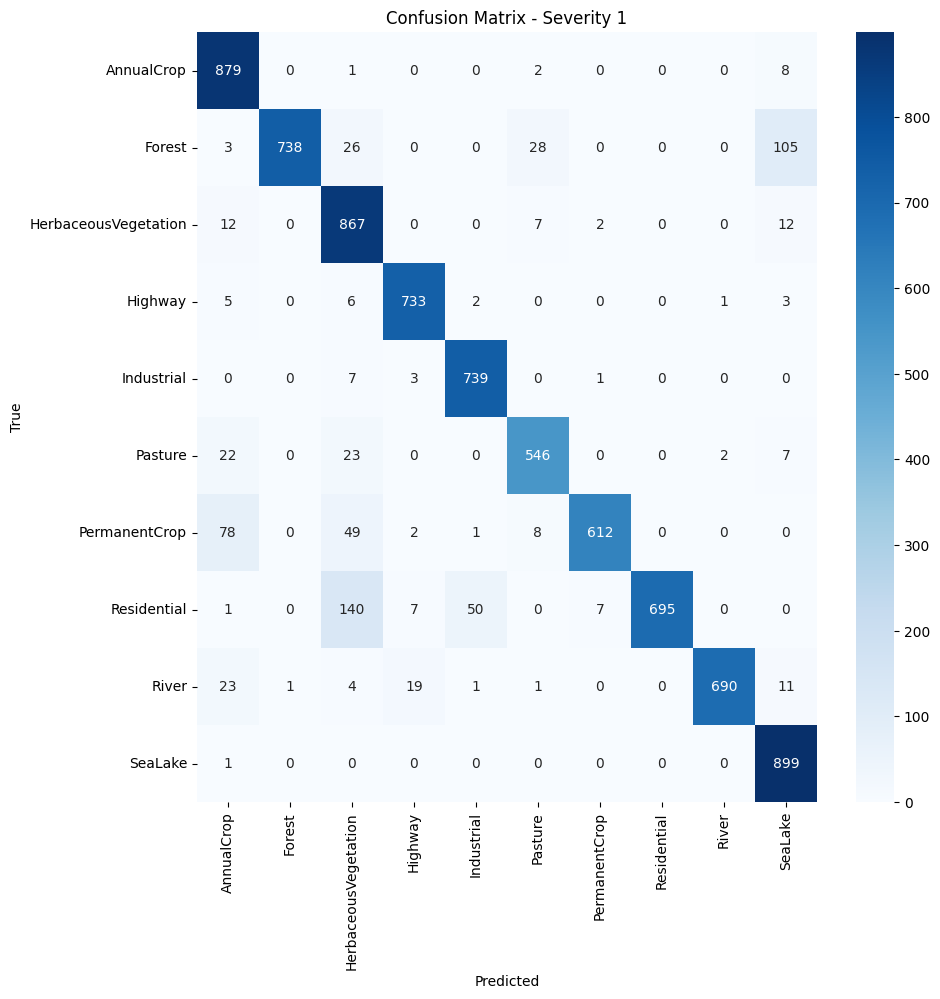

Test results for severity 1: Loss=0.3048463784991012 | Accuracy=91.44622991347343
Precision: 0.9256390994436265 | Recall: 0.9144622991347342
Inference Time: 9.557716608047485 seconds
Robustness score for severity 1: 0.925907384230288

Test results for severity 2: Loss=0.5953668017589119 | Accuracy=84.16563658838072
Precision: 0.8799234201220918 | Recall: 0.8416563658838072
Inference Time: 9.716953992843628 seconds



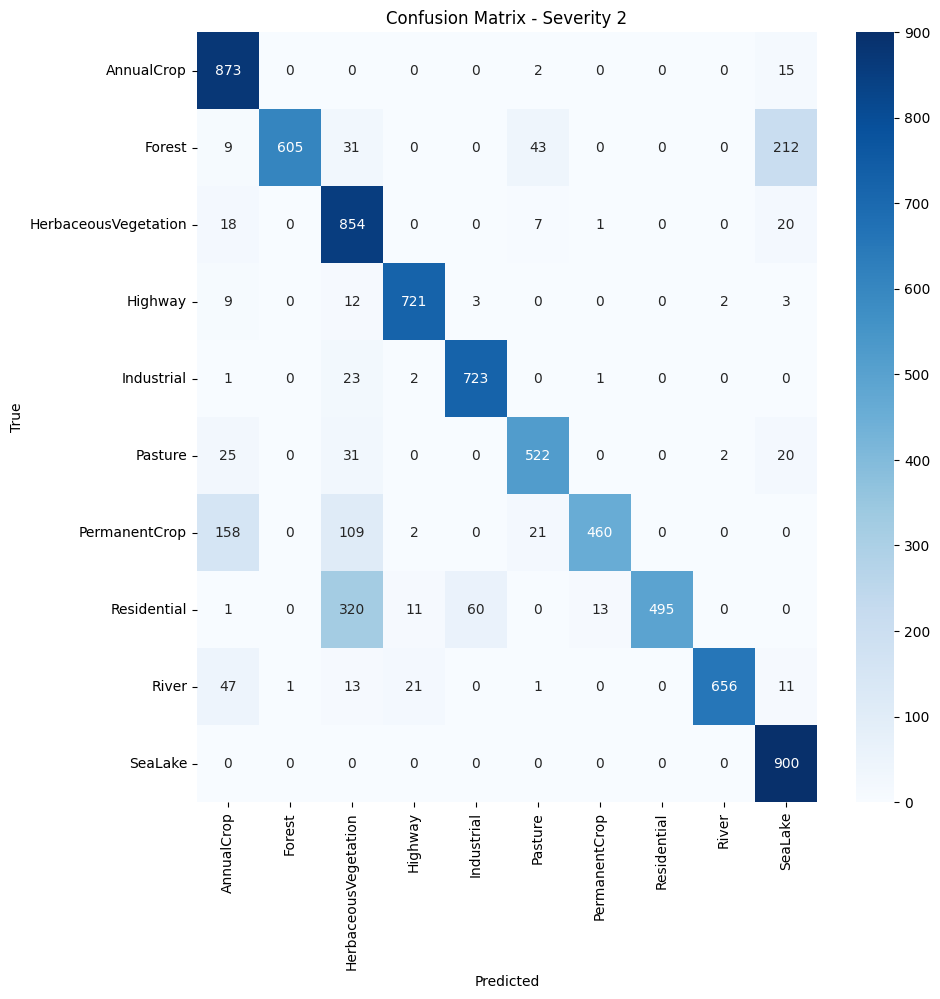

Test results for severity 2: Loss=0.5953668017589119 | Accuracy=84.16563658838072
Precision: 0.8799234201220918 | Recall: 0.8416563658838072
Inference Time: 9.716953992843628 seconds
Robustness score for severity 2: 0.8521902377972466

Test results for severity 3: Loss=2.145061576130523 | Accuracy=58.20766378244747
Precision: 0.7783920902312176 | Recall: 0.5820766378244746
Inference Time: 9.841801881790161 seconds



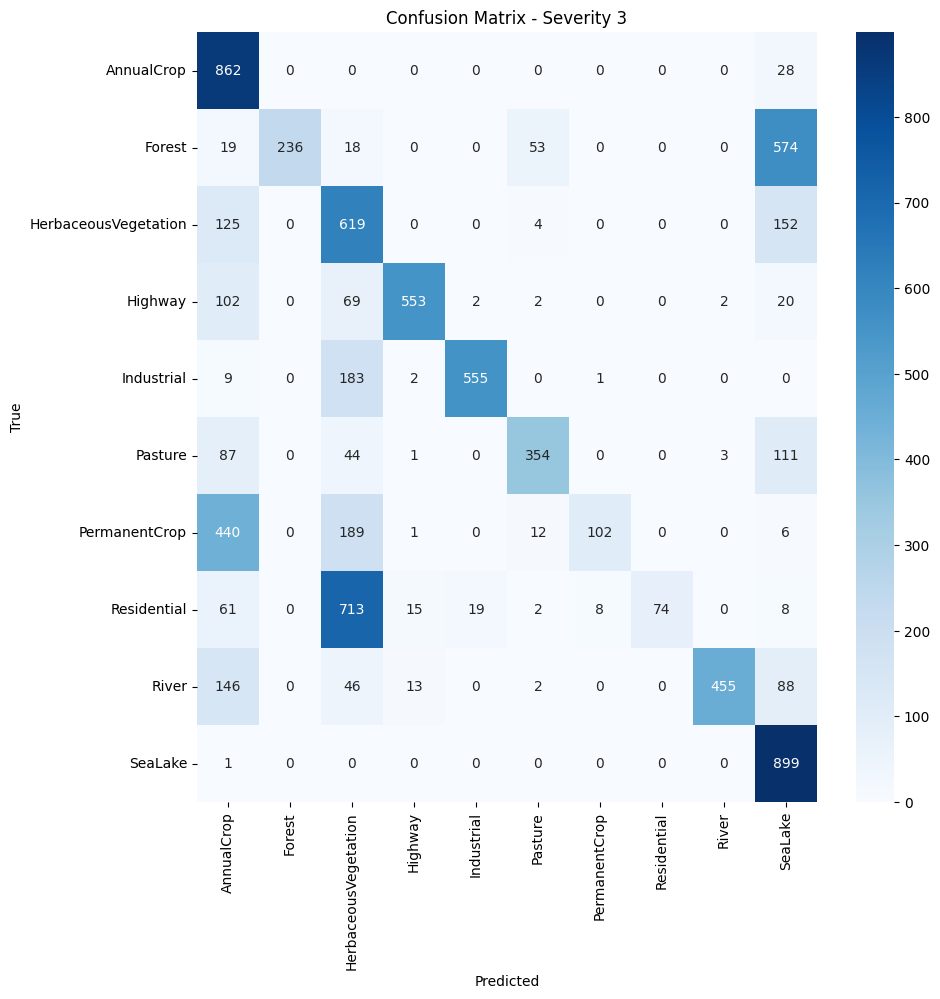

Test results for severity 3: Loss=2.145061576130523 | Accuracy=58.20766378244747
Precision: 0.7783920902312176 | Recall: 0.5820766378244746
Inference Time: 9.841801881790161 seconds
Robustness score for severity 3: 0.5893617021276596

Test results for severity 4: Loss=1.3595312345709045 | Accuracy=70.0370828182942
Precision: 0.8153074468548017 | Recall: 0.7003708281829419
Inference Time: 9.632567167282104 seconds



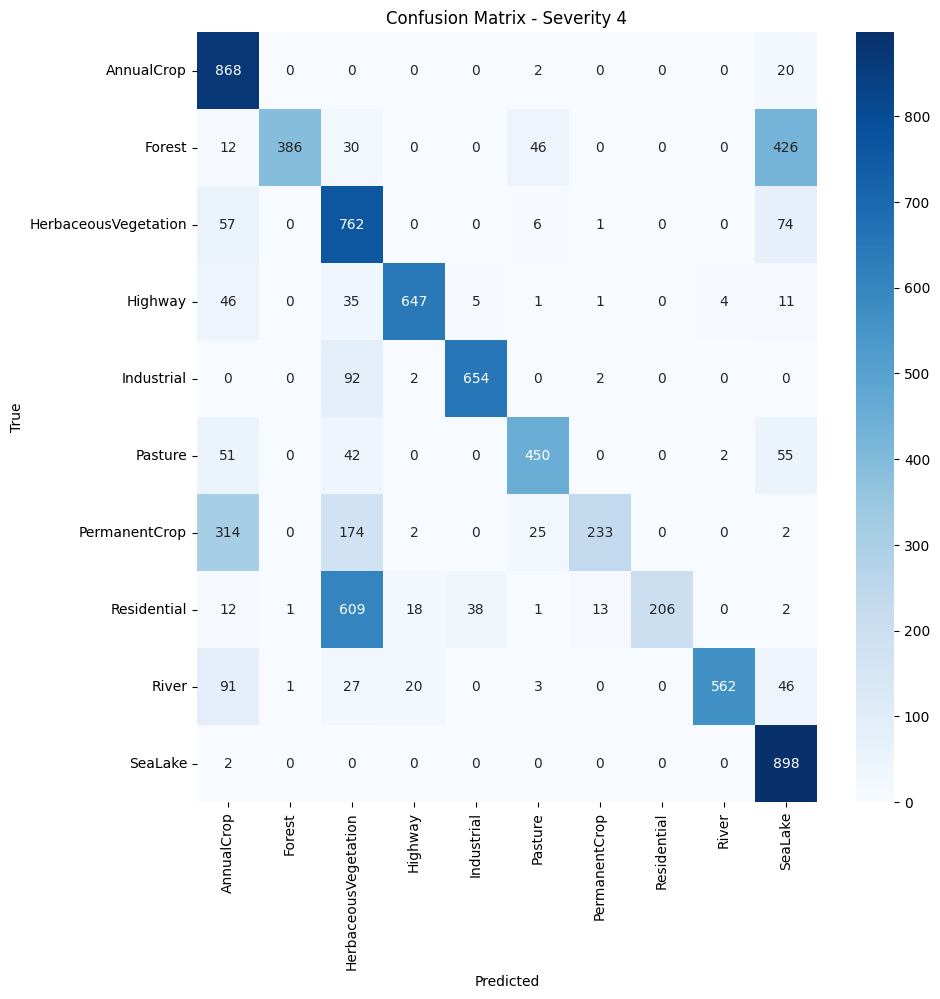

Test results for severity 4: Loss=1.3595312345709045 | Accuracy=70.0370828182942
Precision: 0.8153074468548017 | Recall: 0.7003708281829419
Inference Time: 9.632567167282104 seconds
Robustness score for severity 4: 0.7091364205256571

Test results for severity 5: Loss=2.950595712733563 | Accuracy=48.43016069221261
Precision: 0.7419364487231618 | Recall: 0.4843016069221261
Inference Time: 9.54373025894165 seconds



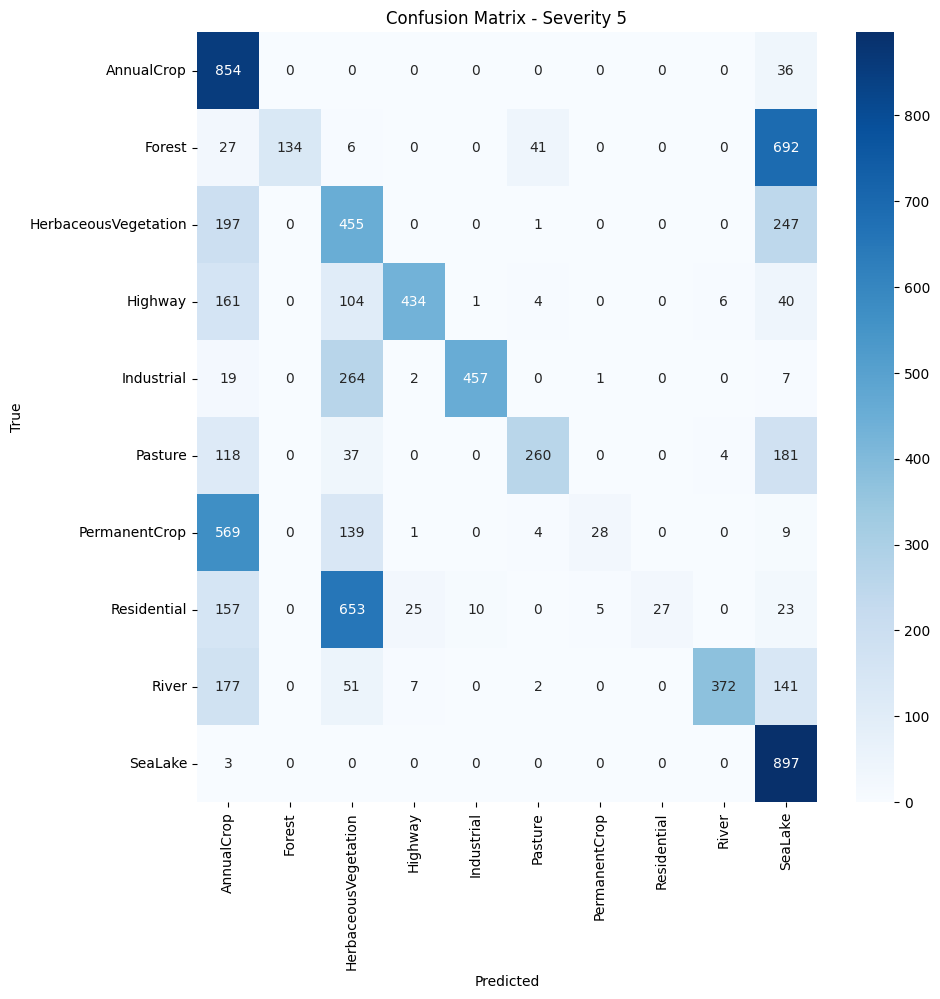

Test results for severity 5: Loss=2.950595712733563 | Accuracy=48.43016069221261
Precision: 0.7419364487231618 | Recall: 0.4843016069221261
Inference Time: 9.54373025894165 seconds
Robustness score for severity 5: 0.49036295369211513
Overall Robustness Score: 0.7133917396745934


In [11]:
# Calculate robustness scores for each severity level
severity_levels = [1, 2, 3, 4, 5]
robustness_scores = []

for severity in severity_levels:
    # Define the data transformation
    data_transforms = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load the noisy test dataset
    noisy_test_path = os.path.join(output_dir, f'severity_{severity}')
    noisy_test_dataset = datasets.ImageFolder(noisy_test_path, data_transforms)
    noisy_test_loader = torch.utils.data.DataLoader(noisy_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Evaluate the model on the noisy test dataset and calculate robustness score
    test_loss, test_accuracy, precision, recall, inference_time, robustness_score = evaluate_and_calculate_robustness(noisy_test_loader, criterion, severity)
    robustness_scores.append(robustness_score)

    # Print the results
    print(f'Test results for severity {severity}: Loss={test_loss} | Accuracy={test_accuracy}')
    print(f'Precision: {precision} | Recall: {recall}')
    print(f'Inference Time: {inference_time} seconds')
    print(f'Robustness score for severity {severity}: {robustness_score}')

# Calculate the overall robustness score
overall_robustness_score = np.mean(robustness_scores)
print(f'Overall Robustness Score: {overall_robustness_score}')